In [1]:
import pandas as pd
import numpy as np

import yfinance as yf

import ta

import matplotlib.pyplot as plt

In [4]:
# Data Extraction

ticker = "BTC-USD"
# ticker='SPY'
start_date = "2016-01-01"
end_date = "2018-01-01"
df = yf.download(ticker,start_date,end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


In [35]:
# Adding Indicators

df['ma_20'] = df['Close'].rolling(window=20).mean()
df['volatility'] = df['Close'].rolling(window=20).std()

df['bb_upper']= df['ma_20'] + (2*df['volatility'])
df['bb_lower']= df['ma_20'] - (1.5*df['volatility'])

df['rsi'] = ta.momentum.rsi(df['Close'],window=14)

df.dropna(inplace=True)

In [46]:
# Defining Conditions

conditions = [
              (df['rsi']<=35) & (df['Close'] <= df['bb_lower']), # Condition to buy
              (df['rsi']>80) & (df['Close'] > df['bb_upper']), # Condition to sell
              ]

actions = [1,-1]

In [47]:
# Creating Signal
# Shift the signal - Buy on the next days open - Sell on the close

df['signal'] = np.select(conditions,actions)
df['signal']=df['signal'].shift(1)
df.loc[df['signal']==1]

,Open,High,Low,Close,Adj Close,Volume,ma_20,volatility,bb_upper,bb_lower,rsi,signal
Date,,,,,,,,,,,,
2016-08-02,606.396973,612.848022,531.333984,547.465027,547.465027,330932992,650.570554,29.118690,708.807934,606.892518,23.805493,1.0
2016-08-03,548.656006,573.359985,541.546997,566.354980,566.354980,207982000,645.984402,34.584229,715.152861,594.108058,30.884317,1.0
2016-08-04,566.328979,579.495972,565.776978,578.289001,578.289001,125292000,641.736102,37.450839,716.637781,585.559843,34.993316,1.0
2016-08-05,578.281006,578.281006,569.981995,575.043030,575.043030,66127900,637.449902,39.978350,717.406603,577.482377,34.394368,1.0
2016-08-06,575.030029,588.395996,569.468994,587.778015,587.778015,80797296,632.865854,40.163721,713.193296,572.620273,38.818830,1.0
2017-03-19,976.729980,1069.910034,976.729980,1036.739990,1036.739990,406648000,1190.982898,80.953504,1352.889905,1069.552642,40.181479,1.0
2017-07-16,1991.979980,2058.770020,1843.030029,1929.819946,1929.819946,1182870016,2435.111011,190.995148,2817.101306,2148.618289,26.569021,1.0
2017-07-17,1932.619995,2230.489990,1932.619995,2228.409912,2228.409912,1201760000,2418.909009,194.234070,2807.377148,2127.557904,43.149659,1.0
2017-09-15,3166.300049,3733.449951,2946.620117,3637.520020,3637.520020,4148069888,4301.085986,399.672870,5100.431727,3701.576681,41.151251,1.0


In [48]:
# Looping the DF to calculate days and prices of we buy/sell

position = {
"in":False,
"index":'',
"price":0
}

prices_dates = []


for index,row in df.iterrows():
  if(not position['in'] and row['signal']==1):
    prices_dates.append({'index':index,"price":row['Open'],"action":'buy'})
    position['index']=index
    position['in'] = True
    position['price']=row['Open']


  if(position['in'] and row['signal']==-1 ):
    prices_dates.append({'index':index,"price":row['Close'],"action":'sell'})
    position['index']=index
    position['in'] = False
    position['price']=0

  # if(position['in'] and position['price']*1.5 <= row['Open']):

  #   print(f"position price is : {position['price']}")
  #   print(f"row price is : {row['Close']}")


  #   prices_dates.append({'index':index,"price":row['Close'],"action":'sell'})
  #   position['index']=index
  #   position['in'] = False
  #   position['price']=0

  if(position['in'] and position['price']*0.85 >= row['Open']):

    prices_dates.append({'index':index,"price":row['Close'],"action":'sell'})
    position['index']=index
    position['in'] = False
    position['price']=0


In [49]:
# Extracting Buy and Sell Dates and Prices
buy_dates,sell_dates = [],[]
buy_prices,sell_prices=[],[]
for price_date in prices_dates:
  if(price_date['action'] == 'buy'):
    buy_dates.append(price_date['index'])
    buy_prices.append(price_date['price'])
  elif(price_date['action'] == 'sell'):
    sell_dates.append(price_date['index'])
    sell_prices.append(price_date['price'])
  else:
    continue

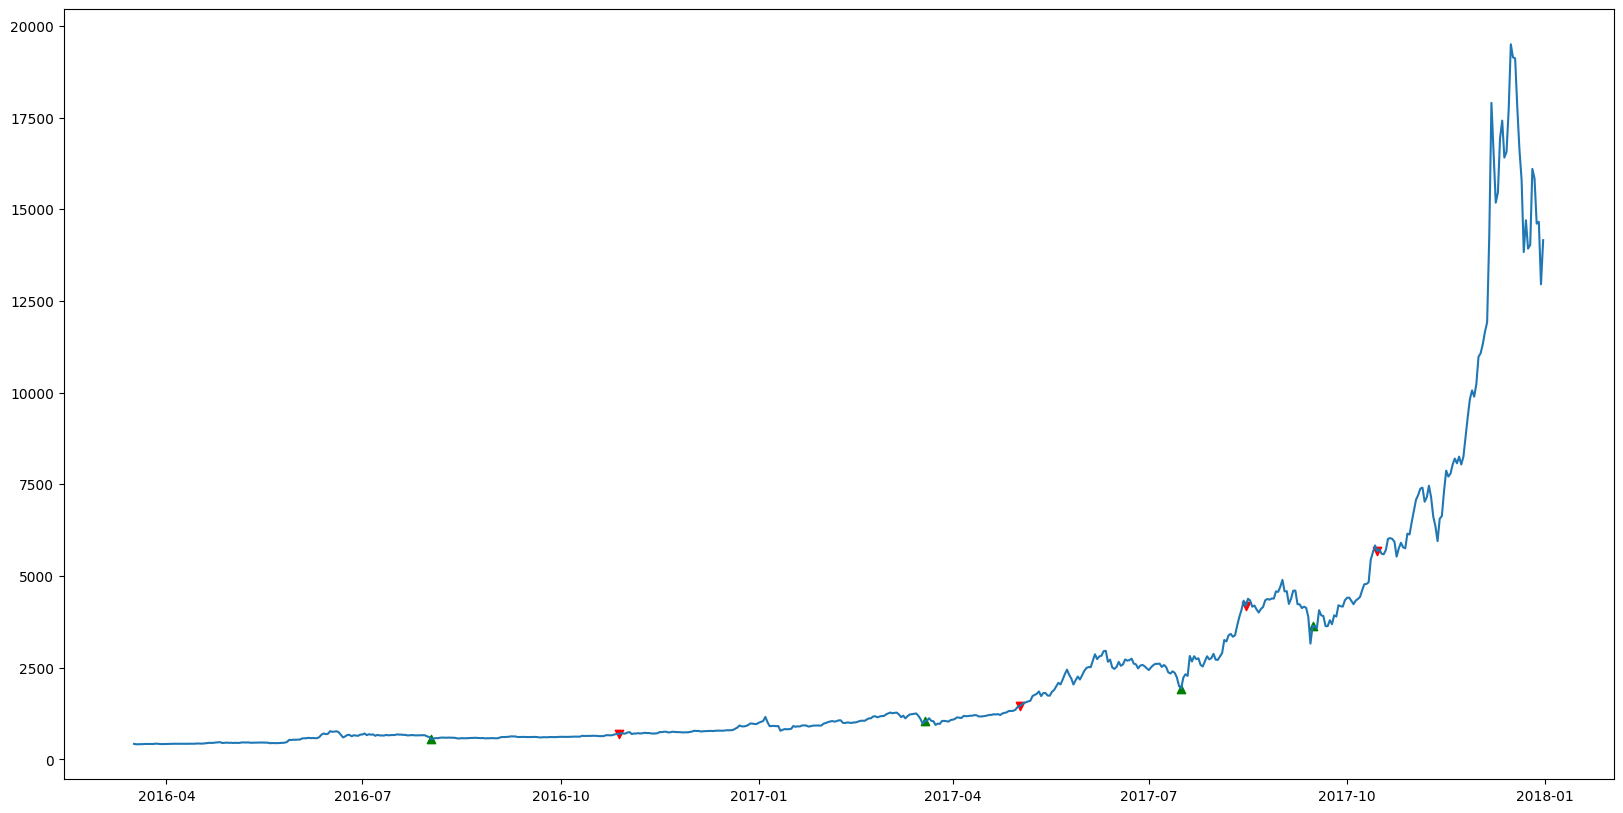

In [50]:
# Plotting
plt.figure(figsize=(20,10))
plt.plot(df['Close'])
plt.scatter(df.loc[buy_dates].index,df.loc[buy_dates].Close,marker='^',c='g')
plt.scatter(df.loc[sell_dates].index,df.loc[sell_dates].Close,marker='v',c='r')

In [51]:
# Calculating Profit

profit = (pd.Series([(sell-buy)/buy for sell,buy in zip(sell_prices,buy_prices)]) + 1).prod() - 1
profit

5.3688244475146325